In [16]:
import cv2, numpy as np

# Lightweight pre-flow heuristics with optional downscale and fast path
# - Downscale to speed up filtering and gradients
# - Replace bilateral with fast Gaussian in the default fast path
# - Keep thresholds tunable

def preflow_mask(img_bgr, k=5, fast=True, downscale=2, thr_dim=0.15, thr_var=0.002, thr_grad=0.02, thr_mineig=1e-6):
    # Optionally downscale for speed
    if downscale and downscale > 1:
        h, w = img_bgr.shape[:2]
        img_small = cv2.resize(img_bgr, (w // downscale, h // downscale), interpolation=cv2.INTER_AREA)
    else:
        img_small = img_bgr

    # 1) intensity (dim)
    gray = cv2.cvtColor(img_small, cv2.COLOR_BGR2GRAY).astype(np.float32)
    Y = gray / 255.0
    dim = (Y < thr_dim)  # too dark

    # 2) local contrast (variance)
    # Use box blur (very fast). Kernel size k kept small by default.
    m  = cv2.blur(Y, (k, k))
    m2 = cv2.blur(Y * Y, (k, k))
    var = np.clip(m2 - m * m, 0, 1)
    low_var = (var < thr_var)

    # 3) gradient magnitude (no edges ⇒ no features)
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx * gx + gy * gy) / 255.0
    low_grad = (grad < thr_grad)

    # 4) structure tensor min-eigenvalue (Shi–Tomasi cornerness)
    # low eigenvalue ⇒ aperture problem
    # For speed, use small block size and ksize.
    min_eig = cv2.cornerMinEigenVal(gray, blockSize=k, ksize=3)
    flat = (min_eig < thr_mineig)

    # Combine: mark as BAD if ANY of these are true
    bad = dim | low_var | low_grad | flat

    # Keep = ~bad
    keep_small = (~bad).astype(np.uint8) * 255

    # Upscale mask back to original size if we downscaled
    if img_small is not img_bgr:
        h0, w0 = img_bgr.shape[:2]
        keep = cv2.resize(keep_small, (w0, h0), interpolation=cv2.INTER_NEAREST)
    else:
        keep = keep_small

    return keep, {"dim": dim, "low_var": low_var, "low_grad": low_grad, "flat": flat}

# Optional: improve lighting before flow (lightweight)
# fast=True avoids bilateral (slow); uses CLAHE + Gaussian blur instead

def preprocess_for_flow(img_bgr, fast=True):
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(y)  # local contrast
    ycrcb = cv2.merge([y, cr, cb])
    out = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    if fast:
        # Very fast smoothing to reduce sensor noise while keeping edges moderately
        out = cv2.GaussianBlur(out, (3, 3), 0)
    else:
        # Higher quality but slower
        out = cv2.bilateralFilter(out, d=5, sigmaColor=25, sigmaSpace=7)
    return out


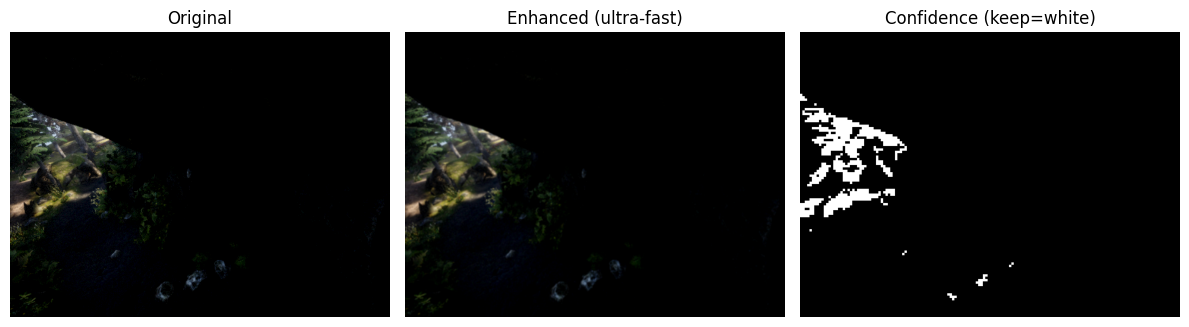

Done in 0.002s (ultra)


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

# --- Load image ---
# img_path = "/home/user/Desktop/DPVO/conf_map_demo/KITTI_sample.png"
img_path = "/home/user/Desktop/DPVO/datasets/mono/ME002/000007.png"
start = time.time()
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {img_path}")

# --- Optional: improve contrast before mask (fast path) ---
img_pre = preprocess_for_flow(img, fast=True)

# --- Compute preflow mask in lightweight mode (downscale=2) ---
keep, masks = preflow_mask(img_pre, k=5, fast=True, downscale=2)
end = time.time()

# --- Visualize compactly ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Enhanced (fast)")
plt.imshow(cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Confidence (keep=white)")
plt.imshow(keep, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

print(f"Done in {end - start:.3f}s")

# Optional: quick glance at factor masks at low resolution (no extra figures)
# Uncomment to debug thresholds
# for key in ["dim", "low_var", "low_grad", "flat"]:
#     plt.figure(figsize=(4, 3))
#     plt.title(key)
#     plt.imshow(masks[key], cmap="gray")
#     plt.axis("off")
#     plt.show()


In [19]:
import os.path as osp

@staticmethod
def seg_read(seg_file):

        if not osp.exists(seg_file):
            print("Segmentation file not found: {}".format(seg_file))
            return None
        
        if seg_file.endswith(".npy"):
            seg = np.load(seg_file)
            return seg.astype(np.int32, copy=False)

        if seg_file.endswith('.png'):
            seg = cv2.imread(seg_file, cv2.IMREAD_UNCHANGED)
            if len(seg.shape) == 3:
                seg = seg[:,:,0] + seg[:,:,1]*256 + seg[:,:,2]*256*256
            return seg.astype(np.int32, copy=False)


In [22]:
seg_path = '/home/user/Desktop/Kumaran/TartanAir-Restructured-new/AbandonedFactory/easy/P000/seg_left/000002_lcam_left_seg.png'

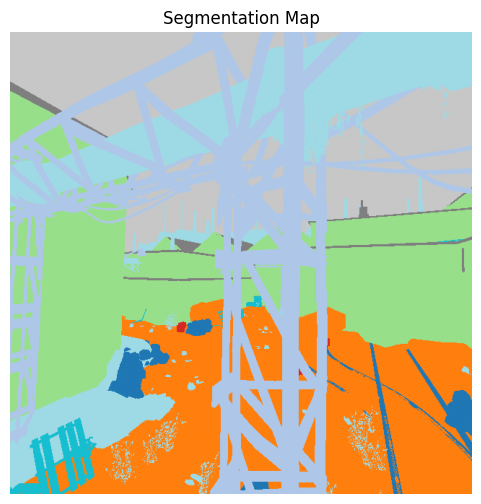

In [23]:
seg_map = seg_read(seg_path)

## Visualize segmentation map
plt.figure(figsize=(6, 6))
plt.title("Segmentation Map")
plt.imshow(seg_map, cmap="tab20")
plt.axis("off")
plt.show()    